# Creation of all plots in paper
This notebook do the following:
1. sync all files, stack all runs, save references
2. non-linear scale for chameleon
3. matter power spectrum


## Syncing
File are copied from `koios:/home/users/vrastil/GIT/FastSim-Jobs/output/` and saved to `/home/michal/Documents/GIT/FastSim/jobs/output/`

In [57]:
import os
os.system("gnome-terminal -e 'bash -c \"/home/michal/Documents/GIT/FastSim/jobs/KOIOS/sync.sh all\" '")

0

## Stack everything

In [64]:
import simpy.power as pwr
import simpy.data as dt
import simpy.plot as pt
import simpy.utils as ut
from simpy.struct import *

from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
in_dir = '/home/michal/Documents/GIT/FastSim/jobs/output/'
out_dir = '/home/michal/Documents/GIT/FastSim/report/clanek/'
stack_infos = dt.stack_all(in_dir=in_dir, return_stack=True, verbose=False)
results = Results(in_dir)
results.info()

Stacking group 16/29	Found stack info but number of files does not seem right. Disregarding any saved data.
Stacking group 24/29	Found stack info but number of files does not seem right. Disregarding any saved data.
Stacking group 29/29	Found stack info but number of files does not seem right. Disregarding any saved data.


CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 1000 Mpc/h  \phi_s = 1.0e-05   n = 0.5  (lin)	num runs = 20
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 1000 Mpc/h  \phi_s = 1.0e-05   n = 0.5  (nl) 	num runs = 4
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-06   n = 0.5  (nl) 	num runs = 44
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05   n = 0.1  (lin)	num runs = 99
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05   n = 0.5  (nl) 	num runs = 26
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05   n = 0.7  (lin)	num runs = 100
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L =

## Non-linear scale for chameleon
1. Compton wavelength $\lambda_c$
2. chameleon field $\chi_a$
3. screening potential $\Phi_{a,scr}$
4. chameleon screening scale $k_{src}$

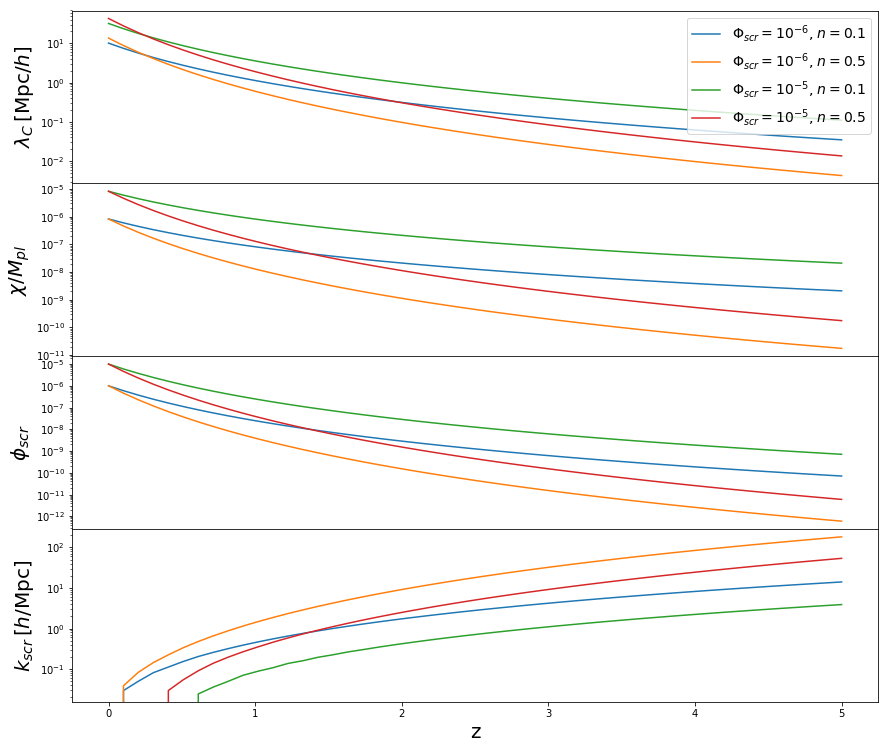

In [60]:
CHI_file = [si.file for si in stack_infos if si.app == 'CHI'][0]
n = [0.1,0.5]
phi = [10**(-6), 10**(-5)]
dt.plot_chi_wave_pot(a_file=CHI_file, outdir=out_dir, n=n, phi=phi)

## Matter Power Spectrum
1. stack runs of the same approximations together (increase resolution range)
2. plot power spectrum at $z=0$ with all approximation, cut to see difference at small scales
3. plot power spectrum relative difference at different redshifts, cut to $k_{nq}/2$
4. plot power spectrum suppresion at three different scales
<> (5. plot slope of the power spectrum)

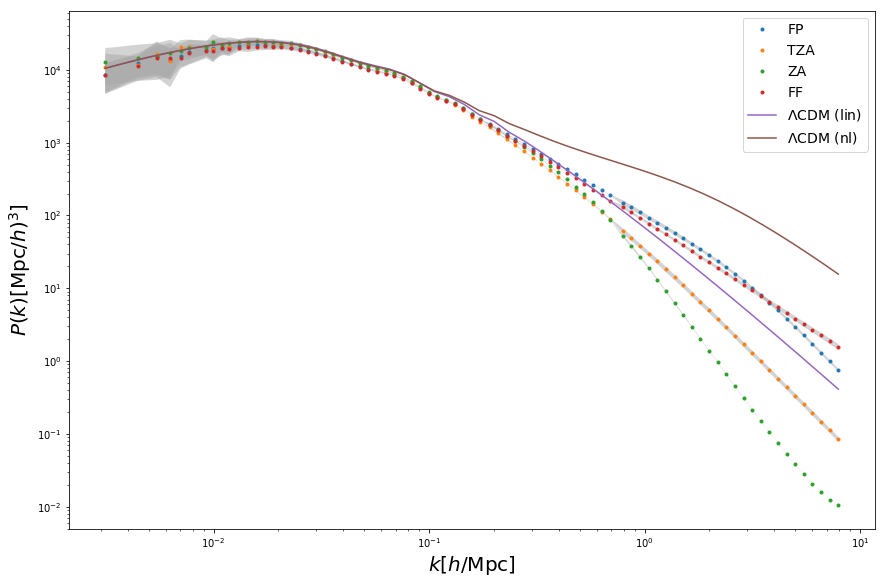

In [61]:
non_chi_stack_infos = results.get_subfiles(NM=1024, app_not='CHI')
dt.get_plot_mlt_pk_broad(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec/', z=0)

**
FF
**


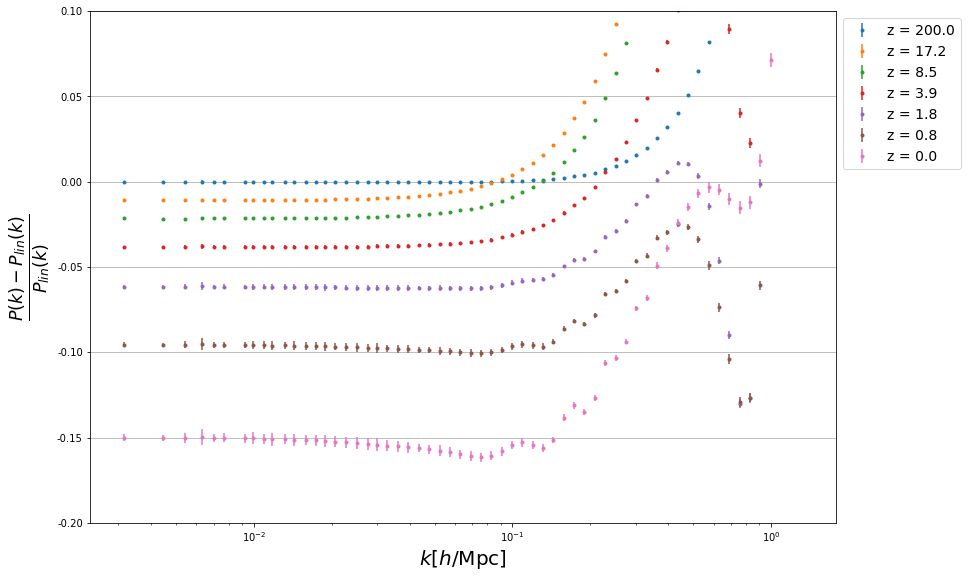

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


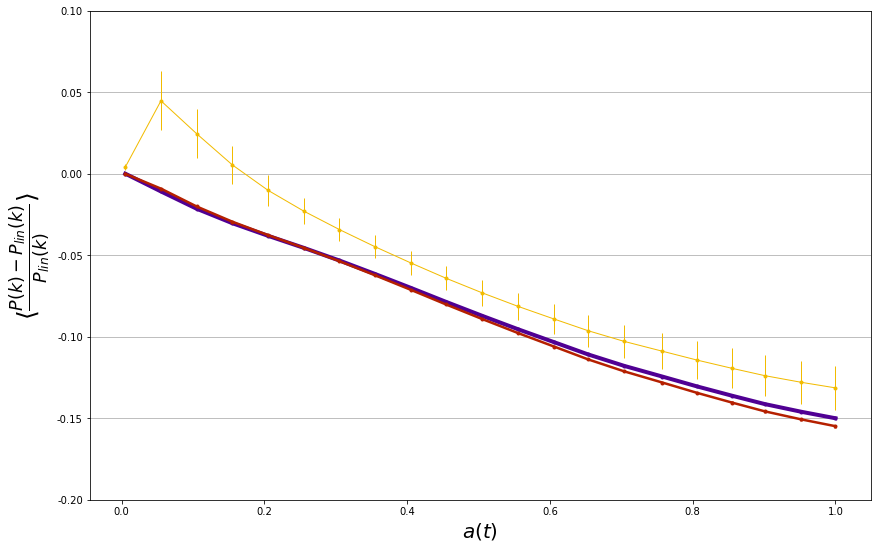

**
FP
**


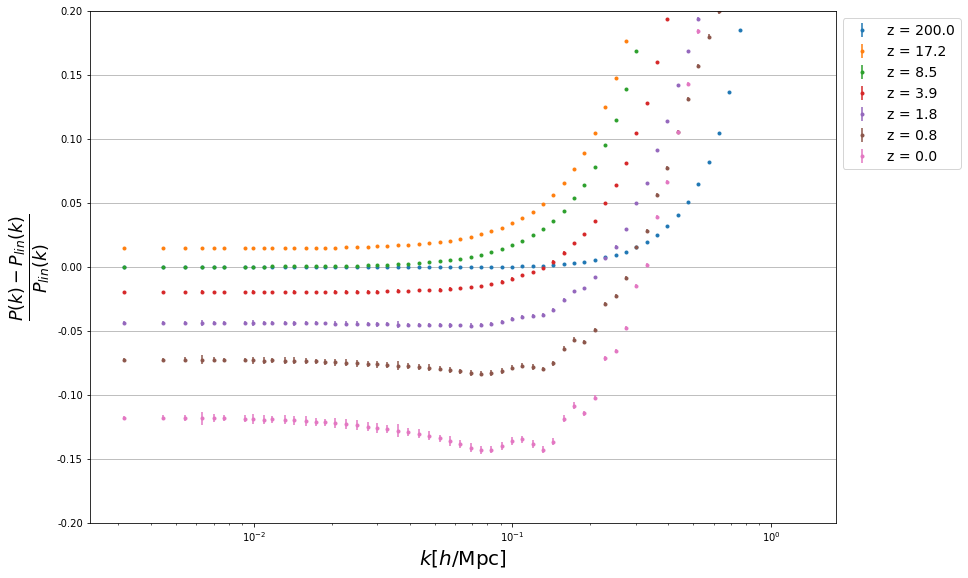

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


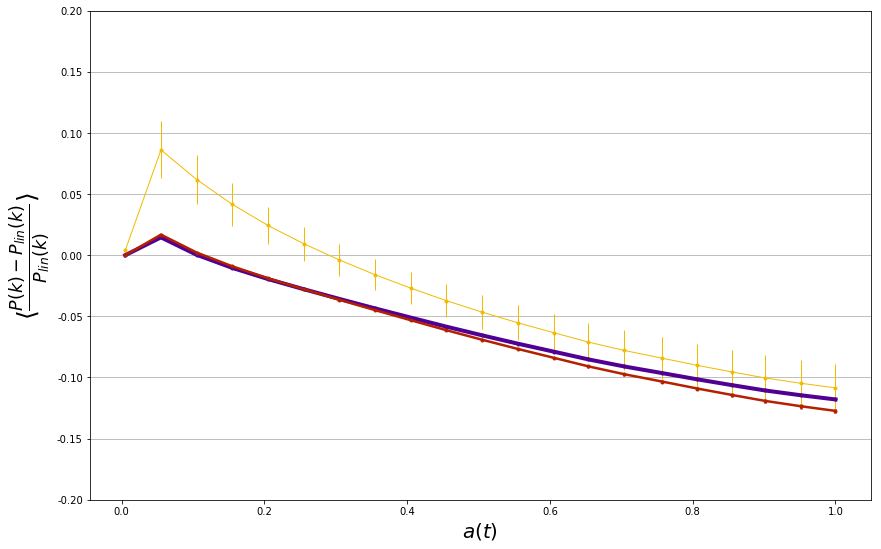

***
TZA
***


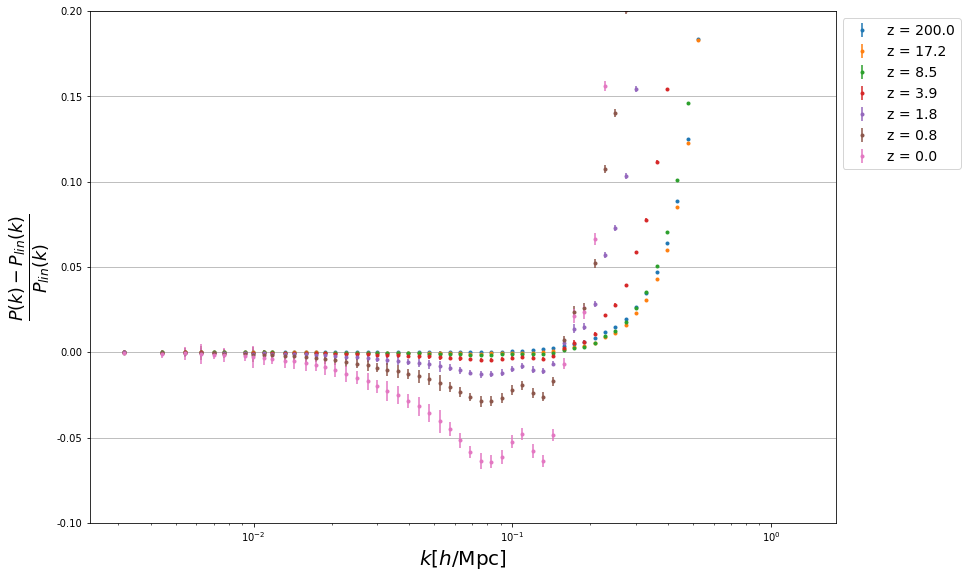

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


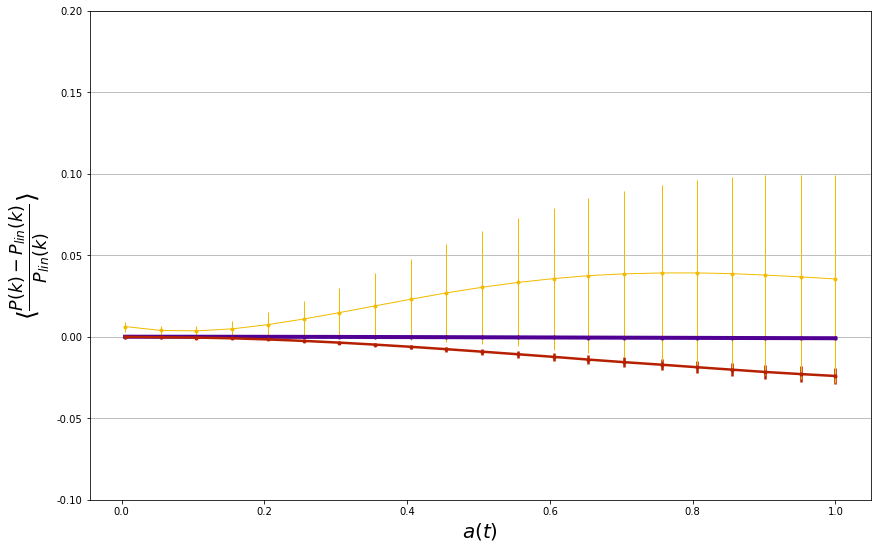

**
ZA
**


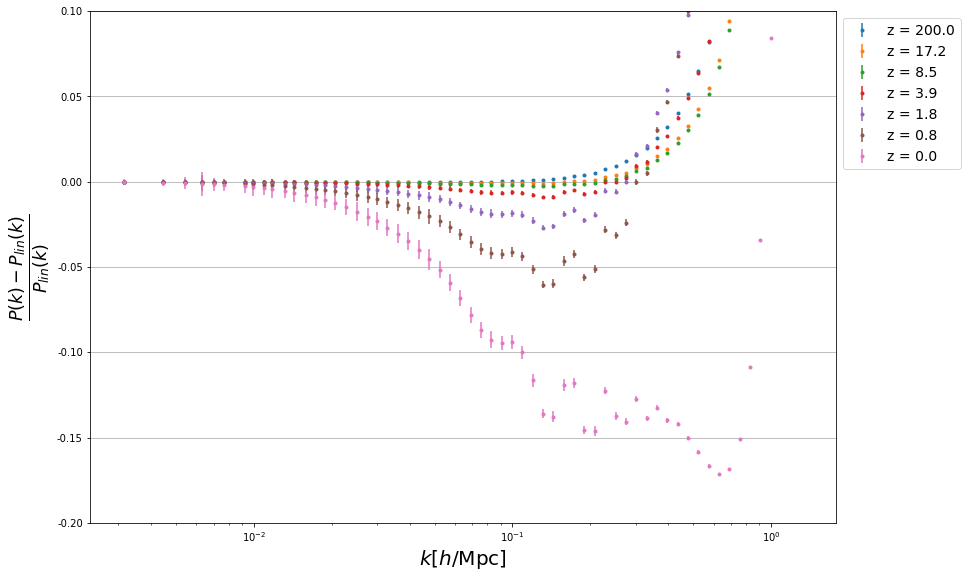

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


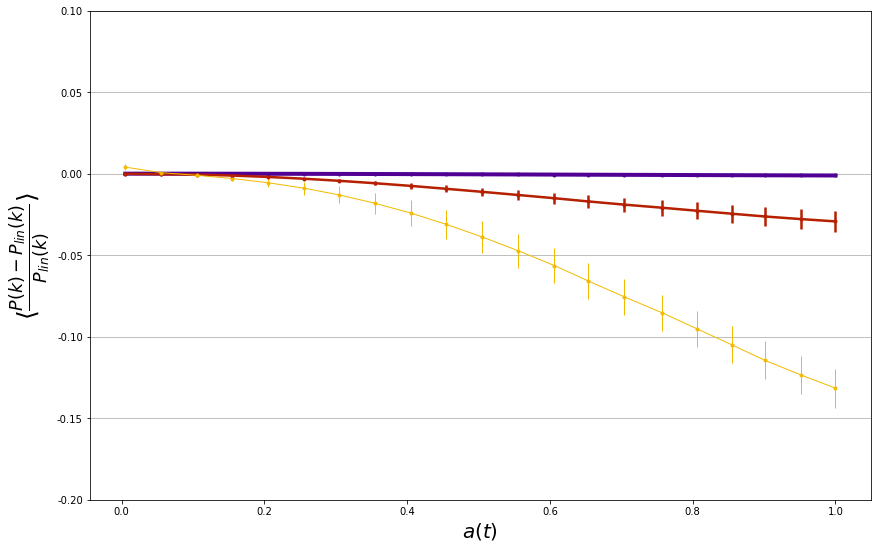

In [65]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
for a_sim_info in non_chi_stack_infos:
    # data
    ut.print_info(a_sim_info.app)
    zs, files = dt.try_get_zs_files(a_sim_info, "pwr_diff", '*input*')
    a = [1./(z+1.) for z in zs if z != 'init']
    data_list = [np.transpose(np.loadtxt(a_file)) for a_file in files]
    supp = dt.load_k_supp(files, a_sim_info.k_nyquist["particle"], a_sim_info=a_sim_info, a=a)
    
    # plots -- diff, supp 
    pt.plot_pwr_spec_diff_from_data(data_list, zs, a_sim_info, out_dir=out_dir + 'pwr_spec/', show_scales=False,
                                 ext_title='init', show=True, add_app=True, max_nyquist=True)
    
    
    pt.plot_supp_lms(supp, a, a_sim_info, out_dir=out_dir + 'pwr_spec/', show=True, add_app=True, scale_in_leg=False)
    
    

## Effective redshift
1. get $a_{eff}$ for each (non-chi) stack_info
2. plot both $P(k)$--type and $\sigma_R$--type
3. plot growth rate $f$

*************************
Effective time: 'sigma_R'
*************************


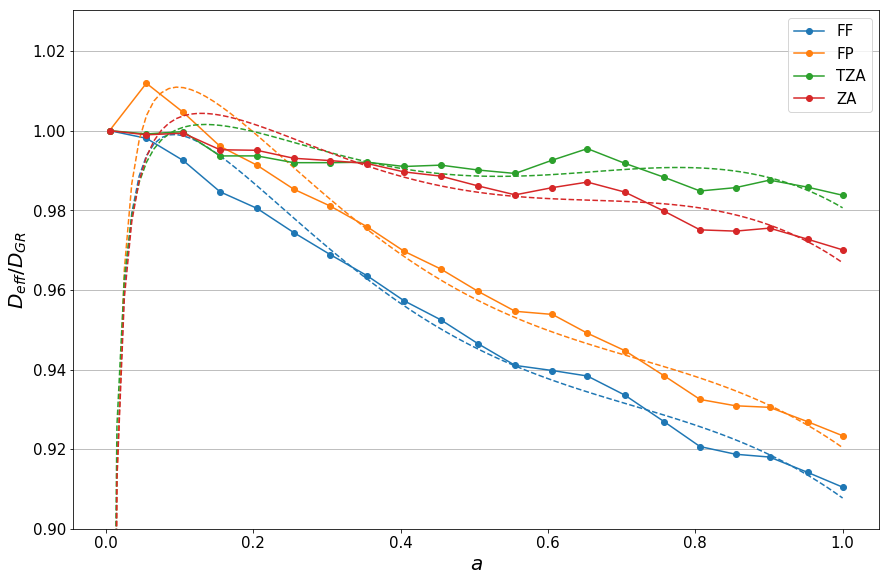

********************
Effective time: 'Pk'
********************


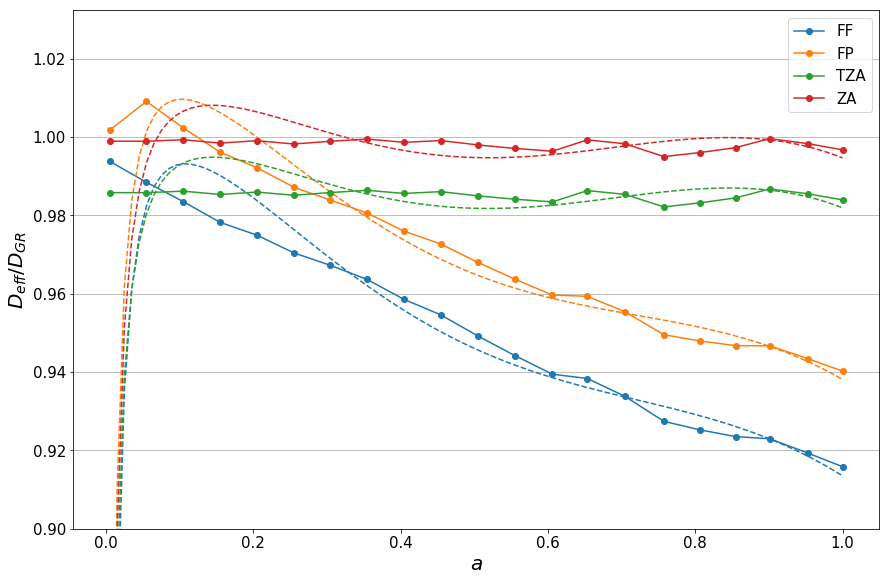

**********************
Growth rate: 'sigma_R'
**********************


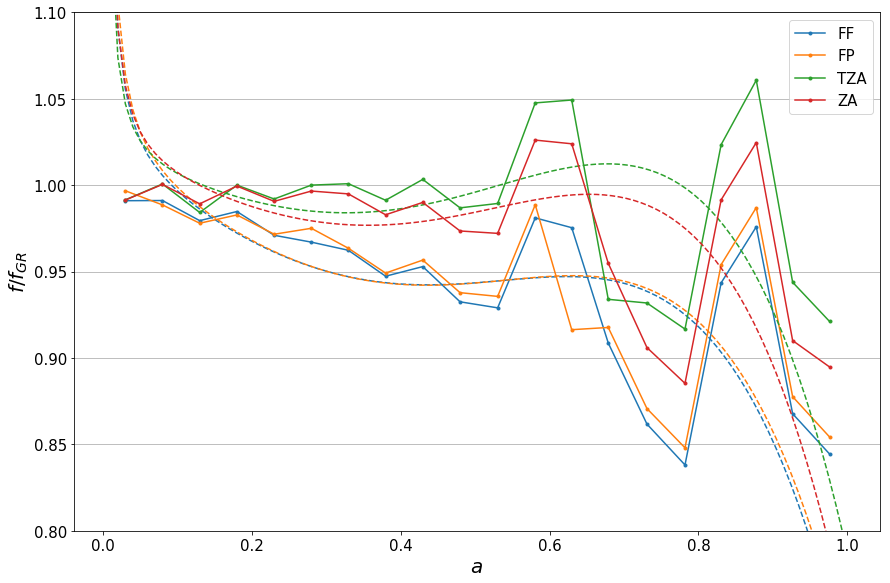

*****************
Growth rate: 'Pk'
*****************


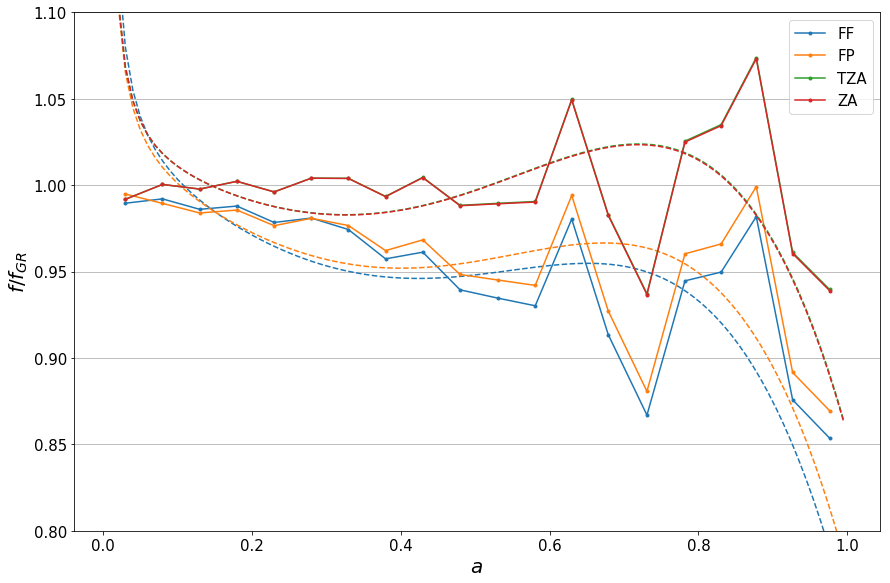

In [126]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
for si in non_chi_stack_infos:
    dt.load_a_eff(si)
pt.plot_eff_time(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="all", show=True)
pt.plot_eff_growth_rate(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="all", show=True)

## Non-linear matter power spectrum
1. stack simulations across different runs (different box sizes)
2. use effective redshift
3. plot power spectrum difference
4. plot power spectrum map
5. amplitude of non-linear power spectrum

FP


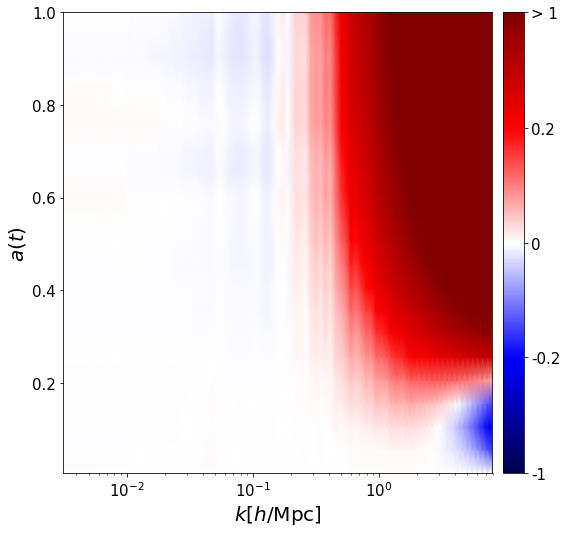

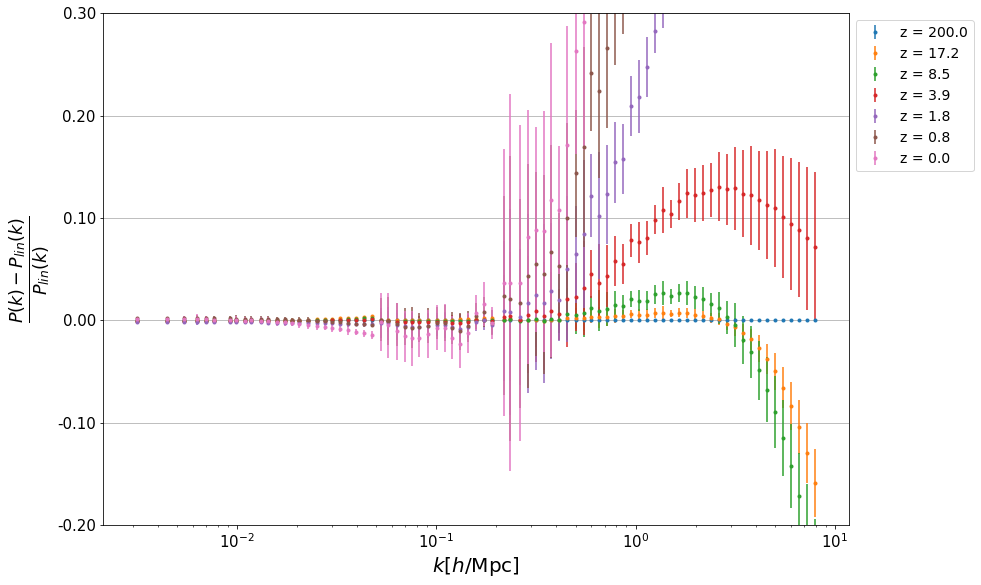

/home/michal/Documents/GIT/FastSim/simpy/data.py:162: RuntimeWarning: invalid value encountered in subtract
  data_array_new[:, 1] -= Pk_init


TZA


/usr/lib64/python2.7/site-packages/matplotlib/colors.py:1133: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


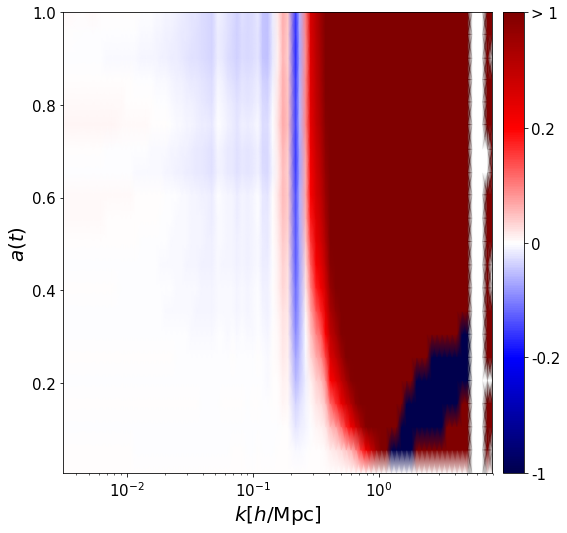

/usr/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


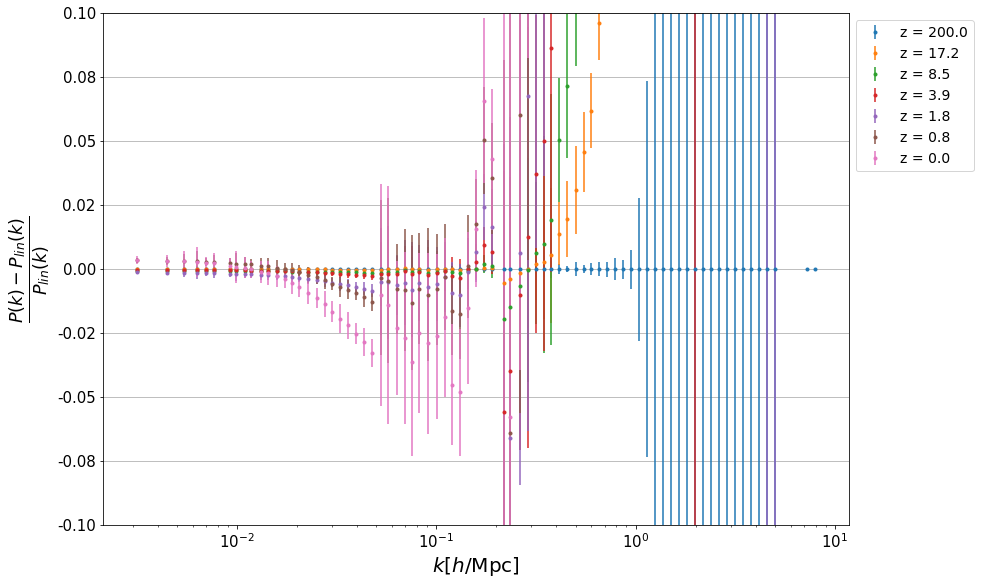

ZA


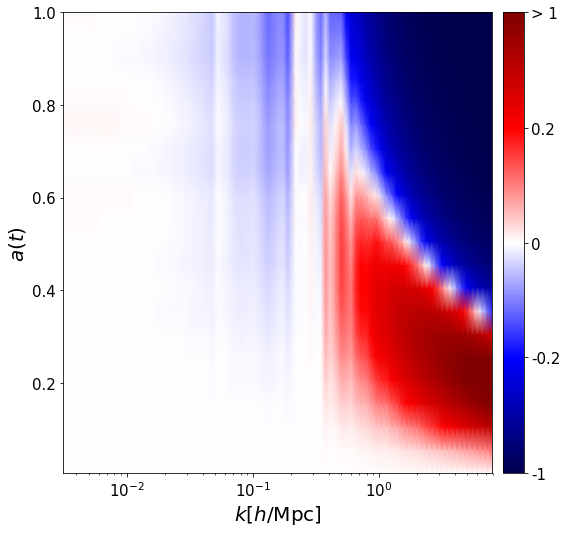

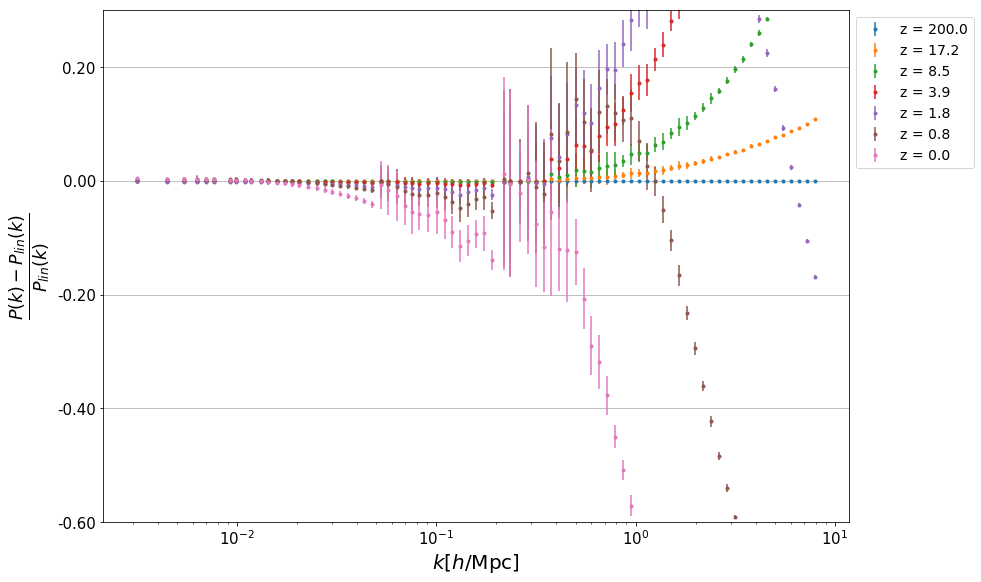

FF


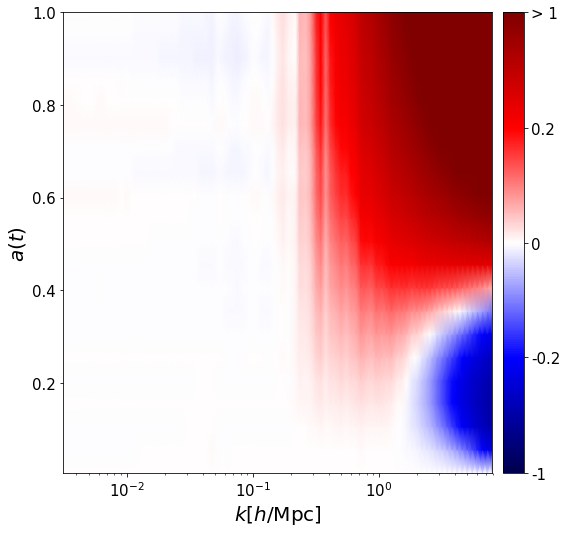

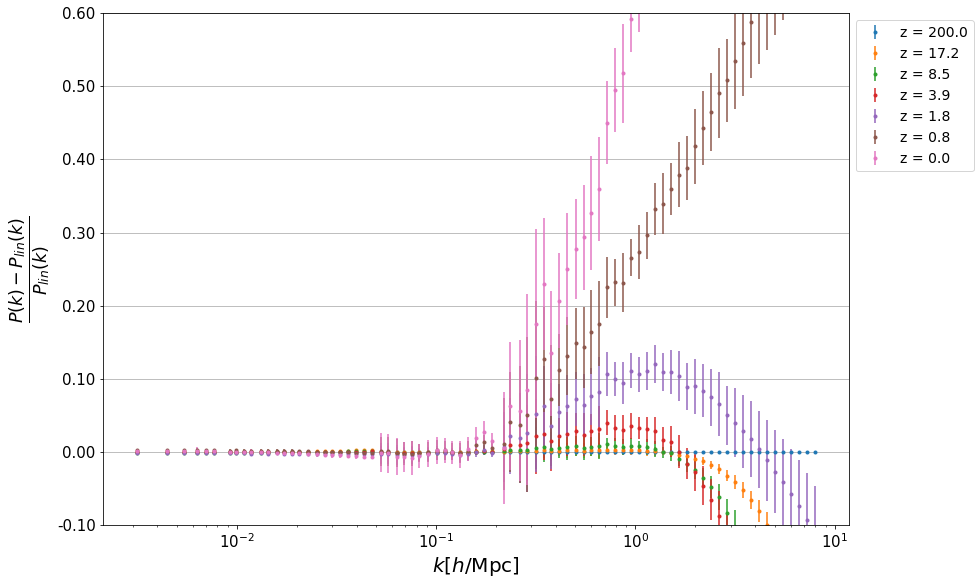

In [127]:
# non_chi_stack_infos = results.get_subfiles(NM=1024,  app_not='CHI')
# for si in non_chi_stack_infos:
#     print si.info_tr()
#     zs, data_array = dt.transform_supp_data_to_z_eff(si)
#     pt.plot_pwr_spec_diff_from_data(data_array, zs, si, show_scales=False, save=False, show=True, use_z_eff=True)
#     pt.plot_pwr_spec_diff_map_from_data(data_array, zs, si, save=False, show=True, use_z_eff=True)
non_chi_stack_infos = results.get_subfiles(NM=1024, app_not='CHI')
dt.get_plot_mlt_pk_diff_broad(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec_nl/')

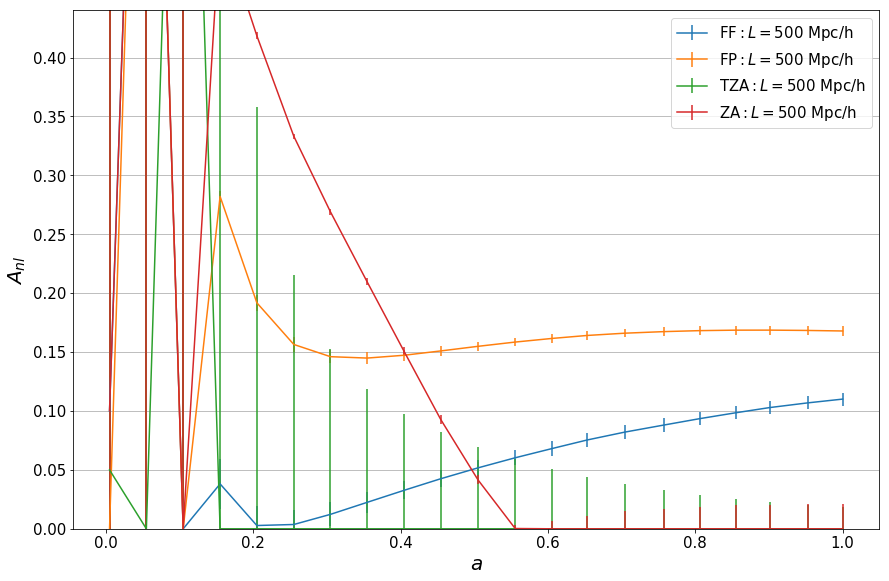

In [129]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=500,  app_not='CHI')
for si in non_chi_stack_infos:
    dt.get_pk_nl_amp(si)
    
pt.plot_pwr_spec_nl_amp(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec_nl/', show=True)

## Correlation function
1. simple correlation function (all approximation)
2. correlation function difference (all approximation)
3. correlation function peak amplitude and location (effective time)

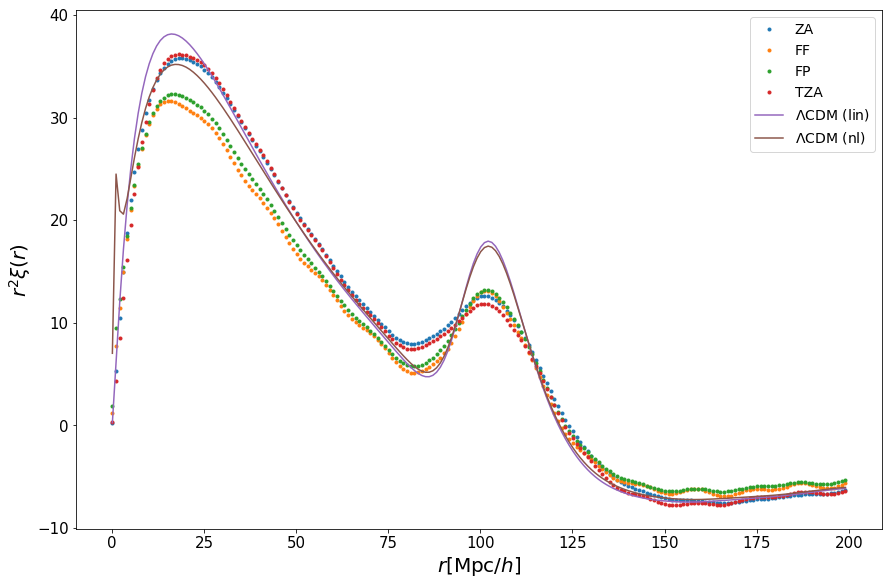

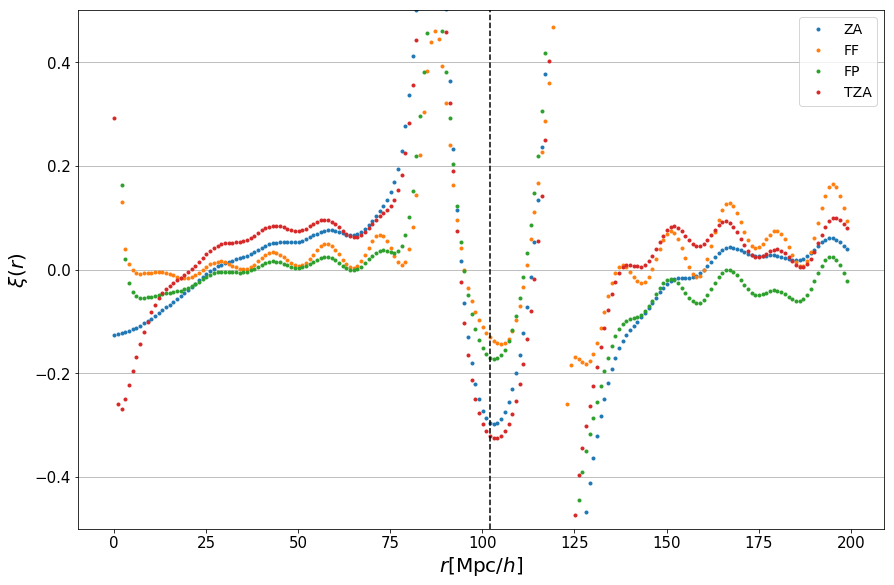

In [130]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
dt.corr_func_comp_plot(sim_infos=non_chi_stack_infos, outdir=out_dir + 'corr_func/', z=0)

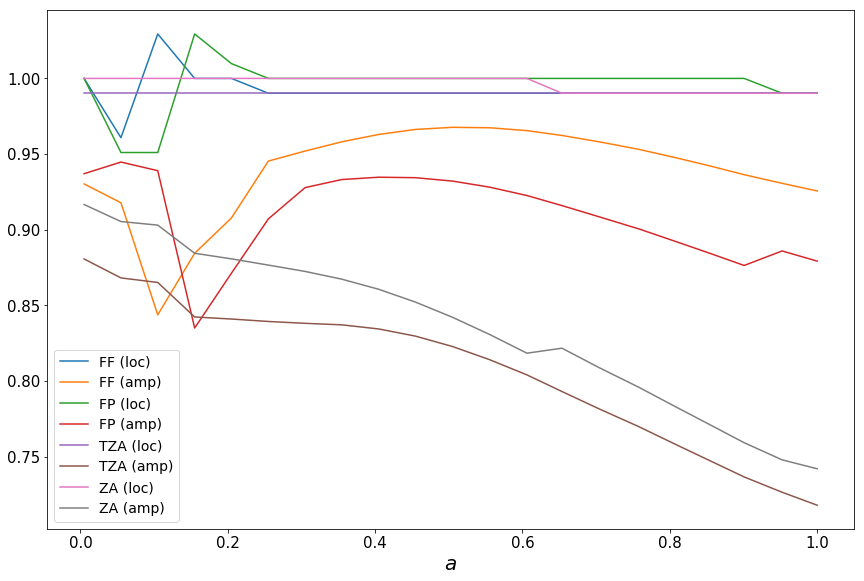

In [131]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
dt.corr_func_comp_plot_peak(sim_infos=non_chi_stack_infos, outdir=out_dir + 'corr_func/')

## Chameleon results
1. effect of simulation resolution on resulting power spectrum
2. growth of structures on different scales (comparison with FPA)
3. compare different chameleon parameters (mainly through BAO peak)

Phi =  1e-05 	n =  0.5


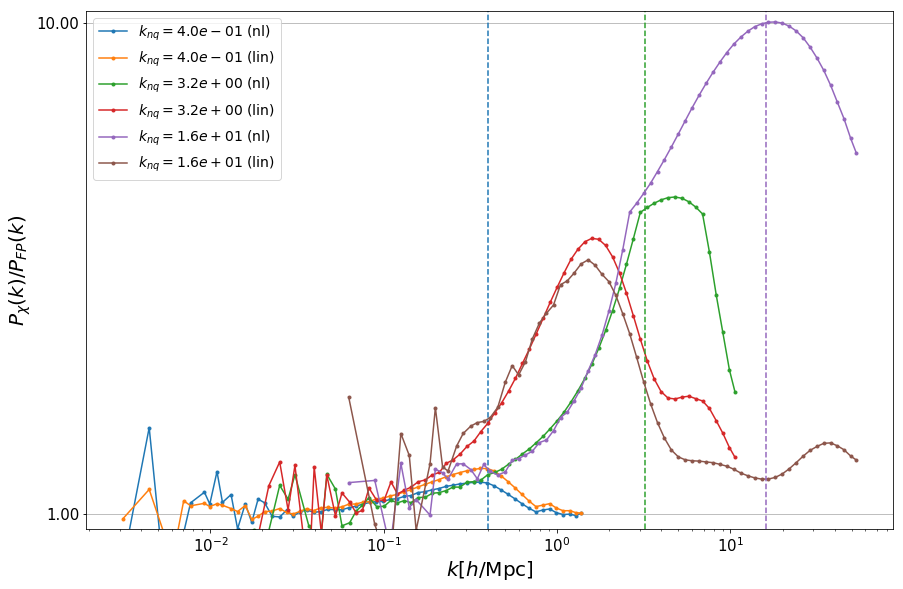

In [237]:
dt.compare_chi_res(in_dir, out_dir + 'chi/')

In [212]:
# results.info(app='CHI')
dt.compare_chi_fp(in_dir=in_dir, out_dir=out_dir + 'chi')

ValueError: could not broadcast input array from shape (3,54) into shape (3)